# Vanishing/Exploding Gradients Problem

## Glorot and He Initialization

In [1]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.shape

torch.Size([10, 40])

In [2]:
layer.weight.data[0]

tensor([-0.0783,  0.1407, -0.0234,  0.1163,  0.1497,  0.0365,  0.1264,  0.1393,
         0.0512,  0.0885, -0.0428,  0.0239,  0.1074, -0.1558, -0.1308,  0.0475,
        -0.0251, -0.0350, -0.0466,  0.0410,  0.1350, -0.0154, -0.0704,  0.1113,
        -0.0100,  0.1416,  0.0723, -0.1012, -0.1335, -0.0661,  0.1448, -0.0511,
        -0.0861,  0.0094, -0.1307,  0.0519,  0.0686,  0.0090, -0.1296,  0.0785])

In [3]:
layer.weight.data *= 6**0.5  # He init

In [4]:
layer.weight.data[0]

tensor([-0.1918,  0.3447, -0.0574,  0.2850,  0.3668,  0.0893,  0.3095,  0.3411,
         0.1253,  0.2167, -0.1048,  0.0585,  0.2632, -0.3816, -0.3203,  0.1164,
        -0.0616, -0.0858, -0.1142,  0.1003,  0.3308, -0.0377, -0.1723,  0.2726,
        -0.0244,  0.3468,  0.1772, -0.2479, -0.3271, -0.1619,  0.3547, -0.1251,
        -0.2110,  0.0230, -0.3201,  0.1272,  0.1680,  0.0220, -0.3175,  0.1923])

In [5]:
layer.bias.data

tensor([ 0.1026,  0.1439,  0.1236,  0.1174,  0.0317, -0.0108,  0.1189,  0.1088,
         0.0825, -0.0807])

In [6]:
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [8]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)
model = nn.Sequential(nn.Linear(40, 30), nn.ReLU(), nn.Linear(30, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=40, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): ReLU()
)

In [9]:
model = nn.Sequential(nn.Linear(40, 10), nn.LeakyReLU(negative_slope=0.2))  # alpha is negative slope
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=40, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

## Better Activation Functions

### Leaky ReLU

In [10]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

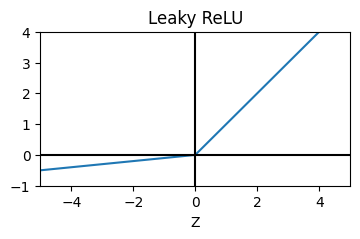

In [11]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-5, 5, 200)
plt.figure(figsize=(4,2))
plt.plot(z, leaky_relu(z,0.1) , "-")
plt.plot([-5,5] ,[0,0] , "k-")
plt.plot([0,0] ,[-1,4] , "k-")
plt.axis([-5, 5 , -1, 4])
plt.title("Leaky ReLU")
plt.xlabel("Z")
plt.axis()
plt.show()

In [12]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2,50)).shape

torch.Size([2, 40])

## Batch Normalization

In [13]:
class MyBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum

        #Learning Parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        #Running stats (for inference time)
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, X):
        if self.training:
            batch_mean = X.mean(dim=0)
            batch_var = X.var(dim=0, unbiased=False)  # by default sample variance(1/N-1),now population variance(1/N)

            #Normalize
            X_hat = (X - batch_mean) / torch.sqrt(batch_var + self.eps)

            #Update running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
        else:
            X_hat = (X - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        out = self.gamma * X_hat + self.beta
        return out

In [14]:
torch.manual_seed(42)
model1 = nn.Sequential(
    nn.Flatten(),
    MyBatchNorm(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    MyBatchNorm(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    MyBatchNorm(100),
    nn.Linear(100, 10)
)

In [15]:
dict(model1[1].named_parameters()).keys()

dict_keys(['gamma', 'beta'])

In [16]:
dict(model1[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var'])

In [17]:
torch.manual_seed(42)

model1.train()
x = torch.randn(2,28,28)
out = model1(x)
out.round(decimals=2)

tensor([[ 0.0200,  1.4500, -0.3600,  0.6600, -0.6800,  0.7700,  0.2500,  0.9700,
          0.0800,  0.8100],
        [ 0.0500, -1.2900,  0.2600, -0.6900,  0.8400, -0.6300, -0.1700, -1.1300,
         -0.0000, -0.6600]], grad_fn=<RoundBackward1>)

In [18]:
torch.manual_seed(42)
model2 = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [19]:
dict(model2[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [20]:
torch.manual_seed(42)

model2.train()
x = torch.randn(2,28,28)
out = model2(x)
out.round(decimals=2)

tensor([[ 0.0200,  1.4500, -0.3600,  0.6600, -0.6800,  0.7700,  0.2500,  0.9700,
          0.0800,  0.8100],
        [ 0.0500, -1.2900,  0.2600, -0.6900,  0.8400, -0.6300, -0.1700, -1.1300,
         -0.0000, -0.6600]], grad_fn=<RoundBackward1>)

## Layer Normalization

In [21]:
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.normalized_shape = normalized_shape

        #Learning Parameters
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, X):
        dims = tuple(range(-len(self.normalized_shape),0))
        mean = X.mean(dim=dims, keepdim=True)
        var = X.var(dim=dims, unbiased=False, keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + self.eps)
        return self.gamma * X_hat + self.beta

In [22]:
torch.manual_seed(42)

inputs = torch.randn(32, 4, 100, 200)
layer_norm = MyLayerNorm([100,200])
result1 = layer_norm(inputs)

In [23]:
torch.manual_seed(42)

inputs = torch.randn(32, 4, 100, 200)
layer_norm = nn.LayerNorm([100,200])
result2 = layer_norm(inputs)

In [24]:
assert torch.allclose(result1, result2)

In [25]:
layer_norm = MyLayerNorm([32, 4, 100, 200])
result3 = layer_norm(inputs)

In [26]:
layer_norm = nn.LayerNorm([32, 4, 100, 200])
result4 = layer_norm(inputs)
assert torch.allclose(result3, result4)

## Gradient Clipping

### Value Clipping

In [27]:
grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
clip_value = 3.0
grad_value_clipped = torch.clamp(grad, min= -clip_value, max=clip_value)
grad_value_clipped

tensor([ 3., -3.,  2.,  3.])

In [28]:
param = nn.Parameter(torch.tensor([10.0, -5.0, 2.0, 8.0]))
param.grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
nn.utils.clip_grad_value_([param], clip_value=3.0)
param.grad

tensor([ 3., -3.,  2.,  3.])

### Norm Clipping

In [29]:
max_norm = 3.0
grad_norm = torch.sqrt(torch.sum(grad**2))
grad_norm

tensor(13.8924)

In [30]:
if grad_norm > max_norm:
    scale = max_norm / grad_norm
    grad_norm_clipped = grad * scale
else:
    grad_norm_clipped = grad

grad_norm_clipped

tensor([ 2.1594, -1.0797,  0.4319,  1.7276])

In [31]:
param = nn.Parameter(torch.tensor([10.0, -5.0, 2.0, 8.0]))
param.grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
nn.utils.clip_grad_norm_([param], max_norm=3.0)
param.grad

tensor([ 2.1594, -1.0797,  0.4319,  1.7276])

In [32]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

# Faster Optimizers

In [34]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, criterion, metric, train_loader, valid_loader, n_epochs):
    history = {"train_losses":[], "train_metrics":[],"valid_metrics":[]}
    for epoch in range(n_epochs):
        total_loss = 0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item()
        )
        print(f"Epoch:{epoch+1}/{n_epochs}, "
             f"Train Loss: {history['train_losses'][-1]:.4f}, "
             f"Train Metric: {history['train_metrics'][-1]:.4f}, "
             f"Valid Metric: {history['valid_metrics'][-1]:.4f}")
    return history


In [35]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [36]:

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader,n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [37]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.04)
history_sgd, acc_sgd = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.5779, Train Metric: 0.7917, Valid Metric: 0.8432
Epoch:2/10, Train Loss: 0.4080, Train Metric: 0.8519, Valid Metric: 0.8448
Epoch:3/10, Train Loss: 0.3665, Train Metric: 0.8661, Valid Metric: 0.8604
Epoch:4/10, Train Loss: 0.3430, Train Metric: 0.8743, Valid Metric: 0.8742
Epoch:5/10, Train Loss: 0.3225, Train Metric: 0.8817, Valid Metric: 0.8776
Epoch:6/10, Train Loss: 0.3077, Train Metric: 0.8866, Valid Metric: 0.8768
Epoch:7/10, Train Loss: 0.2943, Train Metric: 0.8903, Valid Metric: 0.8780
Epoch:8/10, Train Loss: 0.2838, Train Metric: 0.8942, Valid Metric: 0.8754
Epoch:9/10, Train Loss: 0.2754, Train Metric: 0.8969, Valid Metric: 0.8772
Epoch:10/10, Train Loss: 0.2657, Train Metric: 0.9006, Valid Metric: 0.8776


In [38]:
acc_sgd

tensor(0.8719, device='cuda:0')

## Momentum Optimization

In [39]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
history_momentum, acc_momentum = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.6026, Train Metric: 0.7829, Valid Metric: 0.7866
Epoch:2/10, Train Loss: 0.4777, Train Metric: 0.8300, Valid Metric: 0.8430
Epoch:3/10, Train Loss: 0.4487, Train Metric: 0.8408, Valid Metric: 0.8334
Epoch:4/10, Train Loss: 0.4336, Train Metric: 0.8457, Valid Metric: 0.8458
Epoch:5/10, Train Loss: 0.4053, Train Metric: 0.8559, Valid Metric: 0.8426
Epoch:6/10, Train Loss: 0.3997, Train Metric: 0.8572, Valid Metric: 0.8604
Epoch:7/10, Train Loss: 0.3934, Train Metric: 0.8586, Valid Metric: 0.8442
Epoch:8/10, Train Loss: 0.3789, Train Metric: 0.8647, Valid Metric: 0.8556
Epoch:9/10, Train Loss: 0.3758, Train Metric: 0.8662, Valid Metric: 0.8598
Epoch:10/10, Train Loss: 0.3676, Train Metric: 0.8689, Valid Metric: 0.8582


## Nesterov Accelerated Gradient

In [40]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(),lr=0.05, momentum=0.9, nesterov=True)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.5486, Train Metric: 0.8048, Valid Metric: 0.8118
Epoch:2/10, Train Loss: 0.4340, Train Metric: 0.8454, Valid Metric: 0.8336
Epoch:3/10, Train Loss: 0.4070, Train Metric: 0.8564, Valid Metric: 0.8490
Epoch:4/10, Train Loss: 0.3842, Train Metric: 0.8629, Valid Metric: 0.8656
Epoch:5/10, Train Loss: 0.3756, Train Metric: 0.8661, Valid Metric: 0.8528
Epoch:6/10, Train Loss: 0.3681, Train Metric: 0.8690, Valid Metric: 0.8604
Epoch:7/10, Train Loss: 0.3570, Train Metric: 0.8733, Valid Metric: 0.8580
Epoch:8/10, Train Loss: 0.3524, Train Metric: 0.8752, Valid Metric: 0.8538
Epoch:9/10, Train Loss: 0.3428, Train Metric: 0.8764, Valid Metric: 0.8612
Epoch:10/10, Train Loss: 0.3372, Train Metric: 0.8799, Valid Metric: 0.8566


## AdaGrad

In [41]:
model = build_model()
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.5605, Train Metric: 0.8155, Valid Metric: 0.8612
Epoch:2/10, Train Loss: 0.3699, Train Metric: 0.8642, Valid Metric: 0.8678
Epoch:3/10, Train Loss: 0.3351, Train Metric: 0.8762, Valid Metric: 0.8742
Epoch:4/10, Train Loss: 0.3142, Train Metric: 0.8835, Valid Metric: 0.8788
Epoch:5/10, Train Loss: 0.2982, Train Metric: 0.8888, Valid Metric: 0.8802
Epoch:6/10, Train Loss: 0.2865, Train Metric: 0.8928, Valid Metric: 0.8788
Epoch:7/10, Train Loss: 0.2745, Train Metric: 0.8973, Valid Metric: 0.8816
Epoch:8/10, Train Loss: 0.2663, Train Metric: 0.9001, Valid Metric: 0.8802
Epoch:9/10, Train Loss: 0.2582, Train Metric: 0.9036, Valid Metric: 0.8864
Epoch:10/10, Train Loss: 0.2511, Train Metric: 0.9060, Valid Metric: 0.8864


## RMSProp

In [42]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.05, alpha=0.9)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 3.0856, Train Metric: 0.4135, Valid Metric: 0.4846
Epoch:2/10, Train Loss: 1.5592, Train Metric: 0.4054, Valid Metric: 0.3360
Epoch:3/10, Train Loss: 1.5156, Train Metric: 0.4150, Valid Metric: 0.4274
Epoch:4/10, Train Loss: 1.4835, Train Metric: 0.4209, Valid Metric: 0.4244
Epoch:5/10, Train Loss: 1.5939, Train Metric: 0.3872, Valid Metric: 0.4278
Epoch:6/10, Train Loss: 1.5009, Train Metric: 0.4204, Valid Metric: 0.4074
Epoch:7/10, Train Loss: 1.5294, Train Metric: 0.3967, Valid Metric: 0.3342
Epoch:8/10, Train Loss: 1.7418, Train Metric: 0.3270, Valid Metric: 0.2402
Epoch:9/10, Train Loss: 1.6990, Train Metric: 0.3328, Valid Metric: 0.2942
Epoch:10/10, Train Loss: 1.7721, Train Metric: 0.3072, Valid Metric: 0.2708


## Adam

In [43]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05, betas=(0.9,0.999))
history_adam, acc_adam = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 1.4496, Train Metric: 0.4273, Valid Metric: 0.4526
Epoch:2/10, Train Loss: 1.4728, Train Metric: 0.3854, Valid Metric: 0.3730
Epoch:3/10, Train Loss: 1.5609, Train Metric: 0.3434, Valid Metric: 0.2696
Epoch:4/10, Train Loss: 1.6008, Train Metric: 0.3061, Valid Metric: 0.3220
Epoch:5/10, Train Loss: 1.5894, Train Metric: 0.3120, Valid Metric: 0.3034
Epoch:6/10, Train Loss: 1.5993, Train Metric: 0.3094, Valid Metric: 0.2750
Epoch:7/10, Train Loss: 1.6083, Train Metric: 0.3085, Valid Metric: 0.3202
Epoch:8/10, Train Loss: 1.5974, Train Metric: 0.3136, Valid Metric: 0.3124
Epoch:9/10, Train Loss: 1.5901, Train Metric: 0.3151, Valid Metric: 0.3078
Epoch:10/10, Train Loss: 1.6109, Train Metric: 0.3166, Valid Metric: 0.2960


## Adamax

In [44]:
model = build_model()
optimizer = torch.optim.Adamax(model.parameters(),lr=0.05, betas=(0.9,0.999))
history_adamax , acc_adamax = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.6799, Train Metric: 0.7774, Valid Metric: 0.7860
Epoch:2/10, Train Loss: 0.5126, Train Metric: 0.8211, Valid Metric: 0.8344
Epoch:3/10, Train Loss: 0.4768, Train Metric: 0.8340, Valid Metric: 0.8314
Epoch:4/10, Train Loss: 0.4550, Train Metric: 0.8395, Valid Metric: 0.8346
Epoch:5/10, Train Loss: 0.4363, Train Metric: 0.8462, Valid Metric: 0.8404
Epoch:6/10, Train Loss: 0.4283, Train Metric: 0.8491, Valid Metric: 0.8492
Epoch:7/10, Train Loss: 0.4228, Train Metric: 0.8508, Valid Metric: 0.8342
Epoch:8/10, Train Loss: 0.4126, Train Metric: 0.8555, Valid Metric: 0.8402
Epoch:9/10, Train Loss: 0.4131, Train Metric: 0.8538, Valid Metric: 0.8366
Epoch:10/10, Train Loss: 0.4032, Train Metric: 0.8580, Valid Metric: 0.8546


## Nadam

In [45]:
model = build_model()
optimizer = torch.optim.NAdam(model.parameters(),lr=0.05, betas=(0.9,0.99))
history_nadam , acc_nadam = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 2.4217, Train Metric: 0.1069, Valid Metric: 0.1044
Epoch:2/10, Train Loss: 2.3087, Train Metric: 0.0999, Valid Metric: 0.0934
Epoch:3/10, Train Loss: 2.3082, Train Metric: 0.1012, Valid Metric: 0.1054
Epoch:4/10, Train Loss: 2.3085, Train Metric: 0.1011, Valid Metric: 0.0934
Epoch:5/10, Train Loss: 2.3083, Train Metric: 0.1009, Valid Metric: 0.0980
Epoch:6/10, Train Loss: 2.3084, Train Metric: 0.0985, Valid Metric: 0.1016
Epoch:7/10, Train Loss: 2.3086, Train Metric: 0.0971, Valid Metric: 0.0980
Epoch:8/10, Train Loss: 2.3089, Train Metric: 0.0994, Valid Metric: 0.0980
Epoch:9/10, Train Loss: 2.3087, Train Metric: 0.1016, Valid Metric: 0.0994
Epoch:10/10, Train Loss: 2.3089, Train Metric: 0.0982, Valid Metric: 0.1042


## AdamW

In [46]:
model = build_model()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.05, betas=(0.9,0.999),
                             weight_decay=1e-5)
history_adamw, acc_adamw = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 1.3913, Train Metric: 0.4717, Valid Metric: 0.3906
Epoch:2/10, Train Loss: 1.3219, Train Metric: 0.4384, Valid Metric: 0.2046
Epoch:3/10, Train Loss: 2.0523, Train Metric: 0.1827, Valid Metric: 0.1784
Epoch:4/10, Train Loss: 1.9033, Train Metric: 0.1929, Valid Metric: 0.1980
Epoch:5/10, Train Loss: 1.8830, Train Metric: 0.1940, Valid Metric: 0.1974
Epoch:6/10, Train Loss: 1.8693, Train Metric: 0.1953, Valid Metric: 0.2000
Epoch:7/10, Train Loss: 1.8585, Train Metric: 0.1736, Valid Metric: 0.0980
Epoch:8/10, Train Loss: 2.3188, Train Metric: 0.0994, Valid Metric: 0.1006
Epoch:9/10, Train Loss: 2.3152, Train Metric: 0.1022, Valid Metric: 0.0994
Epoch:10/10, Train Loss: 2.3120, Train Metric: 0.0975, Valid Metric: 0.1042


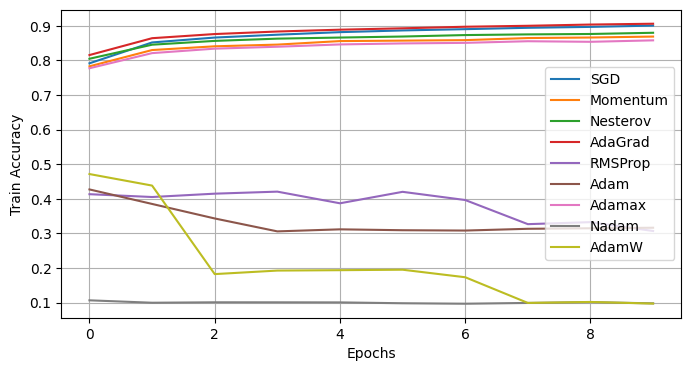

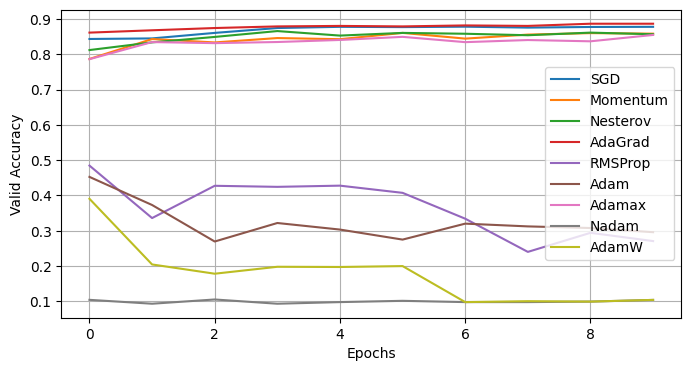

In [47]:
for plot in ("train_metrics","valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw),opt_names.split()):
        plt.plot(history[plot], label=opt_name)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_metrics":"Train Accuracy","valid_metrics":"Valid Accuracy"}[plot])
    plt.legend()
    plt.show()


# Learning Rate Scheduling

### Exponential LR

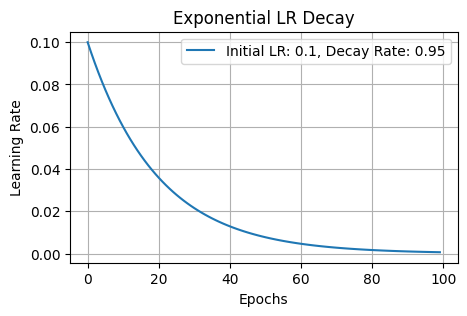

In [48]:
initial_lr = 0.1
decay_rate = 0.95
epochs = 100
epochs_list = np.arange(0, epochs)
lr_decay = initial_lr * decay_rate**epochs_list

plt.figure(figsize=(5, 3))
plt.plot(epochs_list, lr_decay, label=f'Initial LR: {initial_lr}, Decay Rate: {decay_rate}')
plt.title('Exponential LR Decay')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

In [49]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [50]:
def train_with_scheduler(model, optimizer, criterion, metric, train_loader,
                        valid_loader, n_epochs, scheduler):
    history = {"train_losses":[], "train_metrics":[],"valid_metrics":[]}
    for epoch in range(n_epochs):
        total_loss = 0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        valid_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(valid_metric)
        print(f"Epoch:{epoch+1}/{n_epochs}, "
             f"Train Loss: {history['train_losses'][-1]:.4f}, "
             f"Train Metric: {history['train_metrics'][-1]:.4f}, "
             f"Valid Metric: {history['valid_metrics'][-1]:.4f}")
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_metric)
        else:
            scheduler.step()
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def train_scheduler(model, optimizer, scheduler, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_scheduler(model, optimizer, xentropy, metric, train_loader,
                                  valid_loader, n_epochs, scheduler)
    return history, evaluate_tm(model, test_loader, metric)


In [51]:
history_exp, acc_exp = train_scheduler(model, optimizer, exp_scheduler)

Epoch:1/10, Train Loss: 0.6026, Train Metric: 0.7829, Valid Metric: 0.7866
Learning Rate: 0.04500
Epoch:2/10, Train Loss: 0.4659, Train Metric: 0.8351, Valid Metric: 0.8322
Learning Rate: 0.04050
Epoch:3/10, Train Loss: 0.4175, Train Metric: 0.8496, Valid Metric: 0.8400
Learning Rate: 0.03645
Epoch:4/10, Train Loss: 0.3963, Train Metric: 0.8566, Valid Metric: 0.8522
Learning Rate: 0.03281
Epoch:5/10, Train Loss: 0.3598, Train Metric: 0.8695, Valid Metric: 0.8590
Learning Rate: 0.02952
Epoch:6/10, Train Loss: 0.3430, Train Metric: 0.8748, Valid Metric: 0.8604
Learning Rate: 0.02657
Epoch:7/10, Train Loss: 0.3286, Train Metric: 0.8771, Valid Metric: 0.8674
Learning Rate: 0.02391
Epoch:8/10, Train Loss: 0.3158, Train Metric: 0.8821, Valid Metric: 0.8648
Learning Rate: 0.02152
Epoch:9/10, Train Loss: 0.3025, Train Metric: 0.8866, Valid Metric: 0.8642
Learning Rate: 0.01937
Epoch:10/10, Train Loss: 0.2927, Train Metric: 0.8902, Valid Metric: 0.8742
Learning Rate: 0.01743


### Reduce On Plateau

In [52]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)

In [53]:
history_perf, acc_perf = train_scheduler(model, optimizer, perf_scheduler)

Epoch:1/10, Train Loss: 0.6026, Train Metric: 0.7829, Valid Metric: 0.7866
Learning Rate: 0.05000
Epoch:2/10, Train Loss: 0.4777, Train Metric: 0.8300, Valid Metric: 0.8430
Learning Rate: 0.05000
Epoch:3/10, Train Loss: 0.4487, Train Metric: 0.8408, Valid Metric: 0.8334
Learning Rate: 0.05000
Epoch:4/10, Train Loss: 0.4336, Train Metric: 0.8457, Valid Metric: 0.8458
Learning Rate: 0.05000
Epoch:5/10, Train Loss: 0.4053, Train Metric: 0.8559, Valid Metric: 0.8426
Learning Rate: 0.05000
Epoch:6/10, Train Loss: 0.3997, Train Metric: 0.8572, Valid Metric: 0.8604
Learning Rate: 0.05000
Epoch:7/10, Train Loss: 0.3934, Train Metric: 0.8586, Valid Metric: 0.8442
Learning Rate: 0.05000
Epoch:8/10, Train Loss: 0.3789, Train Metric: 0.8647, Valid Metric: 0.8556
Learning Rate: 0.05000
Epoch:9/10, Train Loss: 0.3758, Train Metric: 0.8662, Valid Metric: 0.8598
Learning Rate: 0.00500
Epoch:10/10, Train Loss: 0.2993, Train Metric: 0.8881, Valid Metric: 0.8718
Learning Rate: 0.00500


### With Warmup

In [54]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3
)

In [55]:
# same as above
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch,3)/3) * (1.0 - 0.1) + 0.1)


In [56]:
def train_with_warmup(model, optimizer, criterion, metric, train_loader,
                     valid_loader, n_epochs, warmup_scheduler, scheduler):
    history = {"train_losses":[], "train_metrics":[],"valid_metrics":[]}
    for epoch in range(n_epochs):
        total_loss = []
        metric.reset()
        model.train()

        warmup_scheduler.step()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(total_loss))
        history["train_metrics"].append(metric.compute().item())
        valid_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(valid_metric)
        print(f"Epoch:{epoch+1}/{n_epochs}, "
             f"Train Loss: {history['train_losses'][-1]:.4f}, "
             f"Train Metric: {history['train_metrics'][-1]:.4f}, "
             f"Valid Metric: {history['valid_metrics'][-1]:.4f}")
        if epoch >= 3:
            scheduler.step(valid_metric)

        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_warmup_scheduler(model, optimizer, warmup_scheduler, scheduler,
                         n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)

    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_warmup(model, optimizer, xentropy, metric, train_loader,
                               valid_loader, n_epochs, warmup_scheduler, scheduler)
    return history, evaluate_tm(model, test_loader, metric)


In [57]:
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)
test_warmup_scheduler(model, optimizer, warmup_scheduler, perf_scheduler)

Epoch:1/10, Train Loss: 0.5373, Train Metric: 0.8065, Valid Metric: 0.8118
Learning Rate: 0.00500
Epoch:2/10, Train Loss: 0.4711, Train Metric: 0.8291, Valid Metric: 0.8280
Learning Rate: 0.00500
Epoch:3/10, Train Loss: 0.4694, Train Metric: 0.8354, Valid Metric: 0.8382
Learning Rate: 0.00500
Epoch:4/10, Train Loss: 0.4256, Train Metric: 0.8489, Valid Metric: 0.8450
Learning Rate: 0.05000
Epoch:5/10, Train Loss: 0.3966, Train Metric: 0.8597, Valid Metric: 0.8486
Learning Rate: 0.05000
Epoch:6/10, Train Loss: 0.3801, Train Metric: 0.8651, Valid Metric: 0.8618
Learning Rate: 0.05000
Epoch:7/10, Train Loss: 0.3715, Train Metric: 0.8671, Valid Metric: 0.8430
Learning Rate: 0.05000
Epoch:8/10, Train Loss: 0.3617, Train Metric: 0.8710, Valid Metric: 0.8528
Learning Rate: 0.05000
Epoch:9/10, Train Loss: 0.3484, Train Metric: 0.8761, Valid Metric: 0.8652
Learning Rate: 0.05000
Epoch:10/10, Train Loss: 0.3461, Train Metric: 0.8768, Valid Metric: 0.8534
Learning Rate: 0.05000


({'train_losses': [np.float64(0.5372733105149569),
   np.float64(0.4711299957214503),
   np.float64(0.4694157481939034),
   np.float64(0.4255948946196337),
   np.float64(0.396554780982049),
   np.float64(0.38012972072312967),
   np.float64(0.37150283153274505),
   np.float64(0.3617136004451855),
   np.float64(0.3483742504429945),
   np.float64(0.3460796214813511)],
  'train_metrics': [0.8065090775489807,
   0.8291272521018982,
   0.835381805896759,
   0.8489272594451904,
   0.8597090840339661,
   0.8651272654533386,
   0.8671091198921204,
   0.8710363507270813,
   0.8761454820632935,
   0.8767818212509155],
  'valid_metrics': [0.8118000030517578,
   0.828000009059906,
   0.8381999731063843,
   0.8450000286102295,
   0.8485999703407288,
   0.8618000149726868,
   0.8429999947547913,
   0.8528000116348267,
   0.8651999831199646,
   0.8533999919891357]},
 tensor(0.8436, device='cuda:0'))

### Cyclic LR

Step  0 -> LR = 0.00100
Step  1 -> LR = 0.00267
Step  2 -> LR = 0.00433
Step  3 -> LR = 0.00600
Step  4 -> LR = 0.00433
Step  5 -> LR = 0.00267
Step  6 -> LR = 0.00100
Step  7 -> LR = 0.00267
Step  8 -> LR = 0.00433
Step  9 -> LR = 0.00600
Step 10 -> LR = 0.00433
Step 11 -> LR = 0.00267
Step 12 -> LR = 0.00100


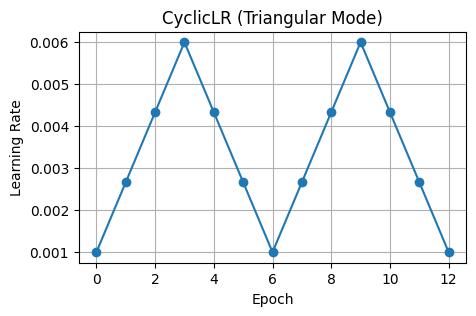

In [58]:

base_lr = 0.001
max_lr = 0.006
stepsize_up = 3
stepsize_down = 3
cycle_steps = stepsize_up + stepsize_down

# Function to compute LR at each step
def get_lr(step):
    cycle_pos = step % cycle_steps
    if cycle_pos <= stepsize_up:  # increasing phase
        return base_lr + (max_lr - base_lr) * (cycle_pos / stepsize_up)
    else:  # decreasing phase
        return max_lr - (max_lr - base_lr) * ((cycle_pos - stepsize_up) / stepsize_down)

# Generate LR values for 2 full cycles
epochs = list(range(13))
lrs = [get_lr(t) for t in epochs]

for t, lr in zip(epochs, lrs):
    print(f"Step {t:2d} -> LR = {lr:.5f}")

plt.figure(figsize=(5, 3))
plt.plot(epochs, lrs, marker='o')
plt.title("CyclicLR (Triangular Mode)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


### Cosine Annealing LR

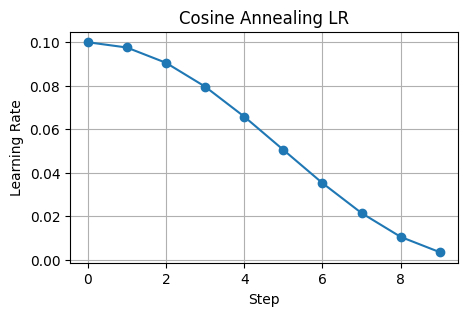

In [59]:
model = torch.nn.Linear(10, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=0.001
)

# Track LRs
lrs = []
steps = list(range(10))

for step in steps:
    lrs.append(optimizer.param_groups[0]['lr'])
    optimizer.step()
    scheduler.step()

plt.figure(figsize=(5,3))
plt.plot(steps, lrs, marker='o')
plt.title("Cosine Annealing LR")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


### Cosine Annealing with Warmup

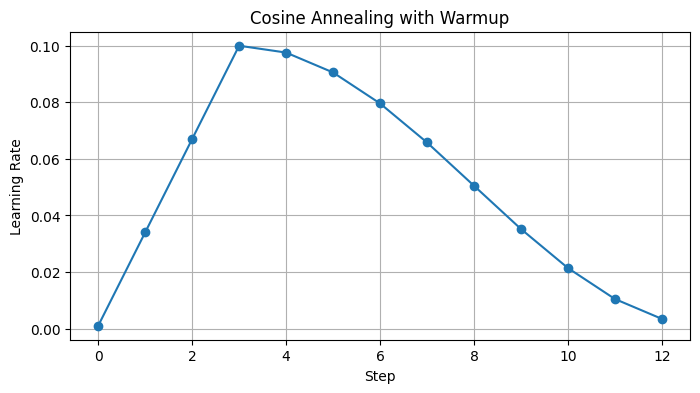

In [60]:
import torch
import math
import matplotlib.pyplot as plt

def cosine_with_warmup_lambda(current_step,eta_min=0.001,eta_max=0.1,warmup_steps=3, total_steps=13):
    base_lr = eta_max
    if current_step < warmup_steps:
        # Linear warmup
        lr = eta_min + (eta_max - eta_min) * current_step / warmup_steps
    else:
        # Cosine decay
        lr = eta_min + 0.5* (eta_max - eta_min) *(
            1+ math.cos(math.pi*(current_step-warmup_steps)/(total_steps-warmup_steps)))
    return lr / base_lr  # scaling factor

# Dummy model
model = torch.nn.Linear(10, 2)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Scheduler
total_steps = 13
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda step: cosine_with_warmup_lambda(step,eta_min=0.001,eta_max=learning_rate, warmup_steps=3, total_steps=total_steps)
)

lrs = []
for step in range(total_steps):
    lrs.append(optimizer.param_groups[0]['lr'])
    optimizer.step()
    scheduler.step()

plt.figure(figsize=(8,4))
plt.plot(range(total_steps), lrs, marker="o")
plt.title("Cosine Annealing with Warmup")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


## Cosine Annealing with Warm Restarts

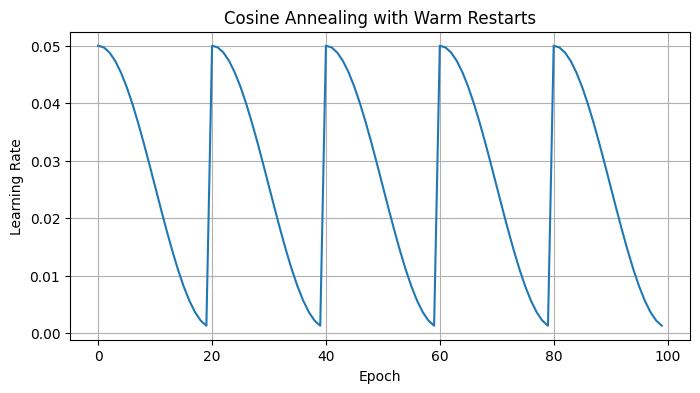

In [61]:

model = torch.nn.Linear(10, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=20,    # first cycle length
    # T_mult=2, # cycle length mutiplier
    eta_min=0.001
)

# Track LRs
lrs = []
steps = 100
for step in range(steps):
    lrs.append(optimizer.param_groups[0]['lr'])
    optimizer.step()
    scheduler.step()

# Plot
plt.figure(figsize=(8,4))
plt.plot(range(steps), lrs)
plt.title("Cosine Annealing with Warm Restarts")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


# Avoiding Overfitting Through Regularization

## ℓ1 and ℓ2 Regularization


In [62]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4) #this will apply regularization to all parameters(w,b,bn,etc) which is not what we want.
history = test_optimizer(model, optimizer)


Epoch:1/10, Train Loss: 0.5705, Train Metric: 0.7923, Valid Metric: 0.8528
Epoch:2/10, Train Loss: 0.4025, Train Metric: 0.8528, Valid Metric: 0.8410
Epoch:3/10, Train Loss: 0.3616, Train Metric: 0.8663, Valid Metric: 0.8688
Epoch:4/10, Train Loss: 0.3377, Train Metric: 0.8747, Valid Metric: 0.8734
Epoch:5/10, Train Loss: 0.3189, Train Metric: 0.8828, Valid Metric: 0.8766
Epoch:6/10, Train Loss: 0.3050, Train Metric: 0.8865, Valid Metric: 0.8714
Epoch:7/10, Train Loss: 0.2927, Train Metric: 0.8907, Valid Metric: 0.8780
Epoch:8/10, Train Loss: 0.2823, Train Metric: 0.8946, Valid Metric: 0.8846
Epoch:9/10, Train Loss: 0.2745, Train Metric: 0.8972, Valid Metric: 0.8788
Epoch:10/10, Train Loss: 0.2641, Train Metric: 0.9015, Valid Metric: 0.8666


##### Internal working

In [63]:
torch.manual_seed(42)
model = nn.Sequential(
        nn.Linear(5, 2),
        nn.Linear(2,1)
        )
for name, param in model.named_parameters():
  print(f"Name: {name}")
  print(f"Shape: {param.shape}")
  print(f"Values:\n{param}\n")

Name: 0.weight
Shape: torch.Size([2, 5])
Values:
Parameter containing:
tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
        [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281]], requires_grad=True)

Name: 0.bias
Shape: torch.Size([2])
Values:
Parameter containing:
tensor([0.3887, 0.0837], requires_grad=True)

Name: 1.weight
Shape: torch.Size([1, 2])
Values:
Parameter containing:
tensor([[0.5224, 0.0958]], requires_grad=True)

Name: 1.bias
Shape: torch.Size([1])
Values:
Parameter containing:
tensor([0.3410], requires_grad=True)



In [64]:
param_to_regularize = [param for name, param in model.named_parameters()
                       if not 'bias' in name and not 'bn' in name]
param_to_regularize[0].shape

torch.Size([2, 5])

In [65]:
l2_loss = sum(param.pow(2).sum() for param in param_to_regularize)
l2_loss

tensor(1.1137, grad_fn=<AddBackward0>)

In [66]:
w =[ torch.tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
        [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281]]),
     torch.tensor([[0.5224, 0.0958]])
]
sum([wn.pow(2).sum() for wn in w])

tensor(1.1136)

In [67]:
a = torch.tensor([2,3,4])
a.pow(2)

tensor([ 4,  9, 16])

##### Custom implementation of ℓ2




In [68]:
n_epochs = 10
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not 'bias' in name and not 'bn' in name
]
for epoch in range(n_epochs):
  total_loss = 0
  total_l2_loss = 0
  for X_batch, y_batch in train_loader:
    model.train()
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    main_loss = loss_fn(y_pred, y_batch)
    l2_loss = sum(param.pow(2).sum() for param in params_to_regularize)
    loss = main_loss + 1e-4 * l2_loss
    total_loss += loss.item()
    total_l2_loss += l2_loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print(f"Epoch: {epoch+1}/{n_epochs} "
         f"Total-Loss: {total_loss/len(train_loader):.3f} "
         f"L2-Loss: {total_l2_loss/len(train_loader):.3f} ")

Epoch: 1/10 Total-Loss: 0.634 L2-Loss: 637.471 
Epoch: 2/10 Total-Loss: 0.467 L2-Loss: 647.278 
Epoch: 3/10 Total-Loss: 0.427 L2-Loss: 649.363 
Epoch: 4/10 Total-Loss: 0.405 L2-Loss: 648.780 
Epoch: 5/10 Total-Loss: 0.387 L2-Loss: 647.507 
Epoch: 6/10 Total-Loss: 0.370 L2-Loss: 646.706 
Epoch: 7/10 Total-Loss: 0.361 L2-Loss: 645.744 
Epoch: 8/10 Total-Loss: 0.351 L2-Loss: 644.799 
Epoch: 9/10 Total-Loss: 0.342 L2-Loss: 644.774 
Epoch: 10/10 Total-Loss: 0.333 L2-Loss: 644.507 


In [69]:
n_epochs = 10
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not 'bias' in name and not 'bn' in name
]
for epoch in range(n_epochs):
  total_loss = 0
  total_l2_loss = 0
  for X_batch, y_batch in train_loader:
    model.train()
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    main_loss = loss_fn(y_pred, y_batch)

    # Divide by batch_size to match the scale of main_loss (averaged per sample)
    # Without division, L2 term would dominate gradients

    l2_loss = sum(param.pow(2).sum() for param in params_to_regularize)/batch_size

    # Add L2 to main loss
    # 1e-4 * l2_loss -> L2 regularization strength
    # As we are adding l2 to main loss , gradients of l2 will be calculated in loss.backward() ∂/∂w(λw**2)= 2λw
    # Multiply by 0.5 to match optimizer weight_decay gradient:

    # loss = main_loss + 1e-4 * l2_loss
    loss = main_loss + 0.5 * 1e-4 * l2_loss

    total_loss += loss.item()
    total_l2_loss += l2_loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print(f"Epoch: {epoch+1}/{n_epochs} "
         f"Total-Loss: {total_loss/len(train_loader):.4f} "
         f"L2-Loss: {total_l2_loss/len(train_loader):.4f} ")

Epoch: 1/10 Total-Loss: 0.5715 L2-Loss: 20.2485 
Epoch: 2/10 Total-Loss: 0.4024 L2-Loss: 21.2092 
Epoch: 3/10 Total-Loss: 0.3614 L2-Loss: 21.9066 
Epoch: 4/10 Total-Loss: 0.3391 L2-Loss: 22.5232 
Epoch: 5/10 Total-Loss: 0.3202 L2-Loss: 23.1029 
Epoch: 6/10 Total-Loss: 0.3020 L2-Loss: 23.6593 
Epoch: 7/10 Total-Loss: 0.2926 L2-Loss: 24.2308 
Epoch: 8/10 Total-Loss: 0.2825 L2-Loss: 24.7957 
Epoch: 9/10 Total-Loss: 0.2732 L2-Loss: 25.3681 
Epoch: 10/10 Total-Loss: 0.2632 L2-Loss: 25.9369 


In [70]:
n_epochs = 4
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
model = build_model()

params_to_regularize = [
    param for name, param in model.named_parameters()
    if not 'bias' in name and not 'bn' in name]
params_bias_and_bn = [
    param for name, param in model.named_parameters()
    if 'bias' in name or 'bn' in name]
optimizer = torch.optim.SGD([
    {"params":params_to_regularize, "weight_decay":1e-4},
    {"params":params_bias_and_bn, "weight_decay":0}
], lr=0.05)

for epoch in range(n_epochs):
  total_loss = 0
  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print(f"Epoch: {epoch+1}/{n_epochs} "
        f"Total-Loss: {total_loss/len(train_loader):.3f} ")

Epoch: 1/4 Total-Loss: 0.570 
Epoch: 2/4 Total-Loss: 0.403 
Epoch: 3/4 Total-Loss: 0.361 
Epoch: 4/4 Total-Loss: 0.337 


## ℓ1 Regularization

In [71]:
torch.manual_seed(42)
model = nn.Sequential(
        nn.Linear(5, 2),
        nn.Linear(2,1)
        )
for name, param in model.named_parameters():
  print(f"Name: {name}")
  print(f"Shape: {param.shape}")
  print(f"Values:\n{param}\n")

Name: 0.weight
Shape: torch.Size([2, 5])
Values:
Parameter containing:
tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
        [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281]], requires_grad=True)

Name: 0.bias
Shape: torch.Size([2])
Values:
Parameter containing:
tensor([0.3887, 0.0837], requires_grad=True)

Name: 1.weight
Shape: torch.Size([1, 2])
Values:
Parameter containing:
tensor([[0.5224, 0.0958]], requires_grad=True)

Name: 1.bias
Shape: torch.Size([1])
Values:
Parameter containing:
tensor([0.3410], requires_grad=True)



In [72]:
w =[ torch.tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
        [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281]]),
     torch.tensor([[0.5224, 0.0958]])
]
sum([wn.abs().sum() for wn in w])

tensor(3.2377)

In [73]:
param_to_regularize = [param for name, param in model.named_parameters()
                       if not 'bias' in name and not 'bn' in name]

In [74]:
l1_loss = sum(param.abs().sum() for param in param_to_regularize)
l1_loss

tensor(3.2378, grad_fn=<AddBackward0>)

In [75]:
n_epochs = 4
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
model = build_model()

optimizer = torch.optim.SGD(model.parameters(),lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not 'bias' in name and not 'bn' in name
]

for epoch in range(n_epochs):
  total_loss = 0
  total_l1_loss = 0
  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    main_loss = loss_fn(y_pred, y_batch)
    l1_loss = sum(param.abs().sum() for param in params_to_regularize)
    total_l1_loss += l1_loss.item()
    loss = main_loss + 1e-4 * l1_loss
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print(f"Epoch: {epoch+1}/{n_epochs} "
         f"Total-Loss: {total_loss/len(train_loader):.4f} "
         f"L1-Loss: {total_l1_loss/len(train_loader):.4f} ")


Epoch: 1/4 Total-Loss: 1.1442 L1-Loss: 5703.5922 
Epoch: 2/4 Total-Loss: 0.9194 L1-Loss: 5098.5916 
Epoch: 3/4 Total-Loss: 0.8286 L1-Loss: 4552.9794 
Epoch: 4/4 Total-Loss: 0.7642 L1-Loss: 4077.4783 


## Dropout

In [76]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2), nn.Linear(28*28, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 10)
).to(device)
model.apply(use_he_init)
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
history_dropout, acc_dropout = test_optimizer(model, optimizer)

Epoch:1/10, Train Loss: 0.6716, Train Metric: 0.7511, Valid Metric: 0.8278
Epoch:2/10, Train Loss: 0.5142, Train Metric: 0.8121, Valid Metric: 0.8424
Epoch:3/10, Train Loss: 0.4834, Train Metric: 0.8220, Valid Metric: 0.8474
Epoch:4/10, Train Loss: 0.4682, Train Metric: 0.8289, Valid Metric: 0.8520
Epoch:5/10, Train Loss: 0.4508, Train Metric: 0.8342, Valid Metric: 0.8538
Epoch:6/10, Train Loss: 0.4441, Train Metric: 0.8378, Valid Metric: 0.8650
Epoch:7/10, Train Loss: 0.4326, Train Metric: 0.8423, Valid Metric: 0.8574
Epoch:8/10, Train Loss: 0.4308, Train Metric: 0.8418, Valid Metric: 0.8676
Epoch:9/10, Train Loss: 0.4191, Train Metric: 0.8461, Valid Metric: 0.8672
Epoch:10/10, Train Loss: 0.4146, Train Metric: 0.8478, Valid Metric: 0.8666


## MC Dropout

In [77]:
x = torch.tensor([[1,2,3,4],[5,6,7,8]])
x_new = x.repeat_interleave(10,dim=0)
x_new

tensor([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8],
        [5, 6, 7, 8]])

In [78]:
model.eval()
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.train()

X_new = torch.FloatTensor(fashion_mnist.data[:3].reshape(3,1,28,28)/255)
X_new = X_new.to(device)

with torch.no_grad():
    X_new_repetead = X_new.repeat_interleave(100, dim=0)
    y_logits_all = model(X_new_repetead).reshape(3,100,10)
    y_probas_all = nn.functional.softmax(y_logits_all, dim=-1)
    y_probas = y_probas_all.mean(dim=1)



In [79]:
y_probas.round(decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0300, 0.0000,
         0.9700],
        [0.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0000, 0.0000,
         0.0000],
        [0.4600, 0.0500, 0.0200, 0.2600, 0.0300, 0.0000, 0.1700, 0.0000, 0.0100,
         0.0000]], device='cuda:0')

In [80]:
y_std = y_probas_all.std(dim=1).round(decimals=2)
y_std

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0000, 0.0500, 0.0000,
         0.0500],
        [0.0300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0300, 0.0000, 0.0000,
         0.0000],
        [0.2000, 0.0600, 0.0200, 0.1500, 0.0600, 0.0000, 0.0600, 0.0000, 0.0100,
         0.0000]], device='cuda:0')

## Max-Norm Regularization

In [83]:
def apply_max_norm(model, max_norm=2, epsilon=1e-8, dim=1):
  with torch.no_grad():
    for name, param in model.named_parameters():
      if 'bias' not in name:
        actual_norm = param.norm(p=2, dim=dim, keepdim=True)
        target_norm = torch.clamp(actual_norm, 0, max_norm)
        param *= target_norm / (actual_norm + epsilon)

In [84]:
n_epochs = 4
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()
model = build_model()
for epoch in range(n_epochs):
  total_loss = 0
  for X_batch, y_batch in train_loader:
    model.train()
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    apply_max_norm(model)
  print(f"Epoch: {epoch+1}/{n_epochs} "
       f"loss: {total_loss/len(train_loader)}")

Epoch: 1/4 loss: 2.4336646698879045
Epoch: 2/4 loss: 2.433682520352109
Epoch: 3/4 loss: 2.4336911063335744
Epoch: 4/4 loss: 2.4336768173075747
